<a href="https://colab.research.google.com/github/imran9891/TensorFlow/blob/main/07_Milestone_project_1_Food_vision_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone project 1: Food Vision Big

## Check GPU

Google Colab offers free GPUs, however, not all of them are compatible with mixed precision training.

Google Colab offers:
* K80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)

Knowing this, in order to use mixed precision training we need access to Tesla T4 (from within Google Colab) or if we're using our own hardware , our GPU needs a score of 7.0+ (see here: https://developer.nvidia.com/cuda-gpus).

**Resource:** You can read more about the benefits of mixed precision training in the TensorFlow Mixed Precision Documentation: https://www.tensorflow.org/guide/mixed_precision

In [1]:
import tensorflow as tf
tf.__version__

'2.6.0'

In [2]:
!pip install tensorflow==2.4.1

     |████████████████████████████████| 394.3 MB 14 kB/s 
     |████████████████████████████████| 3.8 MB 52.4 MB/s 
     |████████████████████████████████| 462 kB 69.6 MB/s 
     |████████████████████████████████| 2.9 MB 12.9 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.39.0
    Uninstalling grpcio-1.39.0:
      Successfully uninstalled grpcio-1.39.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.0
    Uninstalling tensorflow-2.6.

**Note:** Degrading tensorflow version to 2.4.1 for applying the mixed precison float16 to reduce time and improve computation speed as tensorflow 2.5.0 version doesn't support mixed precision using EfficientNetBX models.

In [1]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [2]:
# Check for GPU?
!nvidia-smi

Fri Aug 20 13:05:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get helper functions

In past modules, we have created a bunch of helper functions to do small tasks required for our notebooks.

Rather than wewrite all of these, we can import a script and load them in from there.

The script we've got available can be found on Github: https://raw.githubusercontent.com/imran9891/TensorFlow/main/helper_functions.py

In [3]:
# Download helper functions script
!wget https://raw.githubusercontent.com/imran9891/TensorFlow/main/helper_functions.py

--2021-08-20 13:05:21--  https://raw.githubusercontent.com/imran9891/TensorFlow/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-20 13:05:21 (103 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, unzip_data, plot_loss_curves, compare_historys, walk_through_dir

## Use TensorFlow Datasets to download data

If you want to get an overview of TensorFlow Datasets (TFDS), read the guide: https://www.tensorflow.org/datasets/overview

Read more about the data here: https://www.tensorflow.org/datasets/catalog/food101

In [5]:
# Get tensorflow datasets
import tensorflow_datasets as tfds

In [6]:
# List all available datasets
datasets_list  = tfds.list_builders() # get all available datasets in TFDS 
print('food101' in datasets_list) # is our taf=rget dataset in the list of TFDS datasets

True


In [8]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train","validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple format (data, label)
                                             with_info=True)

## Exploring the Food101 data from TensorFlow datasets

To become one with our data, we want to find:
* Class Names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names?

In [9]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [10]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [11]:
train_data

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [12]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [13]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [15]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape},
  Image datatype: {image.dtype},
  Target class from Food101 (tensor form): {label},
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3),
  Image datatype: <dtype: 'uint8'>,
  Target class from Food101 (tensor form): 30,
  Class name (str form): deviled_eggs
  


In [16]:
# What does our image tensor from TFDS's Food101 look like?
image[:2]

<tf.Tensor: shape=(2, 512, 3), dtype=uint8, numpy=
array([[[28, 31, 50],
        [27, 30, 49],
        [21, 23, 44],
        ...,
        [17, 28, 60],
        [20, 30, 65],
        [28, 38, 73]],

       [[11, 14, 33],
        [23, 26, 45],
        [24, 26, 47],
        ...,
        [39, 50, 82],
        [33, 44, 76],
        [19, 30, 62]]], dtype=uint8)>

In [17]:
# What are the min and max values of our image tensor?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an image from TensorFlow Datasets

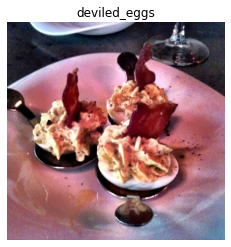

In [18]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label])
plt.axis(False);

## Create preprocessing functions for our data

Neural Networks performs best when data is in a certain way (e.g. batched, normalized etc).

However, not all data (including data from TensorFlow Datasets) comes like this.

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data.

What we know about our data:
* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

What we know models like:
* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size
* Scales (values between 0 and 1) also called normalized tensors generally perform better

With these points in mind, we've got a few things we can tackle with a preprocessing function.

Since we're going to be using an EfficientNetBX pretrained model from tf.keras.applications we don't need to rescale our data (these architectures have rescaling built-in).

This means our functions need to:
1. Reshape our images to all the same size
2. Convert the dtype of our image tensors from `uint8` to `float32`

**Note:** Currently our data is in a (image, label) tuple format


In [19]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from `uint8` -> `float32` and reshapes
  image to [img_shape,img_shape,color_channels]
  """
  image = tf.image.resize(image, size=(img_shape,img_shape)) # reshape target images
  # image = image/255. # scale image values (not required with EfficientNetBX models)
  return tf.cast(image, dtype=tf.float32), label # return a tuple of (float32_image, label) tuple

In [20]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...., \nShape: {image.shape}, \nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}\n")

Image before preprocessing:
 [[[28 31 50]
  [27 30 49]
  [21 23 44]
  ...
  [17 28 60]
  [20 30 65]
  [28 38 73]]

 [[11 14 33]
  [23 26 45]
  [24 26 47]
  ...
  [39 50 82]
  [33 44 76]
  [19 30 62]]]...., 
Shape: (512, 512, 3), 
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[21.801022 24.801022 43.80102 ]
  [17.7551   19.7551   40.755104]
  [16.16837  18.16837  41.16837 ]
  ...
  [37.61732  46.831585 75.964294]
  [30.214298 41.2143   72.02044 ]
  [26.163052 36.80591  69.877335]]

 [[22.091837 23.091837 43.09184 ]
  [10.974489 11.974489 31.97449 ]
  [16.112244 17.112244 38.112244]
  ...
  [45.48988  57.48988  81.20421 ]
  [42.413116 54.34169  80.49475 ]
  [33.551304 45.479874 71.76559 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>



## Batch and prepare datasets

We're now going to make our data input pipelines run really fast.

For more resources on this, check here: https://www.tensorflow.org/guide/data_performance

In [21]:
# Map preprocessing function to training (and parellelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [22]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

> "Hey, TensorFlow , map this preprocessing function (`preprocess_img`) accross our training dataset, then shuffle a number of elements and then batch them together and finally make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) the current batch".

## Create modelling callbacks

We're going to create a couple of callbacks to help us while our model trains:
* TensorBoard callback to log training results (so we can visualize them later if needed).
* ModelCheckpoint callback to save our model's progress after feature extraction


In [23]:
# Create tensorboard callback (import from helper_functions.py)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0) # don't print whether or not model is being saved

## Setup mixed precision training 

First and foremost, for a deeper understanding of mixed precision training, check out the TensorFlow guide for mixed precision: https//www.tensorflow.org/guide/mixed_precision 

Mixed precision utilizes a combination of float16 and float32 data types to speed up model performance.

In [24]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [25]:
mixed_precision.global_policy()

<Policy "mixed_float16">

**Exercise:** 

* Read about single precision floating point format: https://en.wikipedia.org/wiki/Single-precision_floating-point_format

* Read about half precision floating point format: https://en.wikipedia.org/wiki/Half-precision_floating-point_format

## Build feature extraction model

In [26]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create a base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup input layer
inputs = layers.Input(shape=input_shape,name="input_layer")

# Note: EfficientNetBX models have rescaling built-in but if your model doesn't you can have a layer like below
# x = preprocessing.Rescaling(1/255.) (inputs)

# Passing input through base model
x = base_model(inputs, training=False) # makes sure layers which should be in inference mode only or stays like that

# Passing through pooling layer
x = layers.GlobalAveragePooling2D(name='pooling_layer')(x)

# Passing through Dense layer
x = layers.Dense(len(class_names)) (x)

# Creating output layer
outputs = layers.Activation("softmax", dtype=tf.float32, name='softmax_float32')(x)

# Combining the model
model = tf.keras.Model(inputs,outputs)

# Compile the model
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

16711680/16705208 [==============================] - 0s 0us/step


In [27]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [28]:
label

<tf.Tensor: shape=(), dtype=int64, numpy=30>

## Checking layer dtype policies (are we using mixed precision?)

In [29]:
# Check the dtype policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:
* `layer.name`: the human readable name of the particular layer
* `layer.trainable`: is the layer trainable or not? (if `False` the weights are frozen)
* `layer.dtype`: the data type a layer stores its variables in
* `layer.dtype_ploicy`: the data type policy a layer computes on its variables with 

In [30]:
# Check for the base model
for i, layer in enumerate(base_model.layers):
  print(i, layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

0 input_1 False float32 <Policy "float32">
1 rescaling False float32 <Policy "mixed_float16">
2 normalization False float32 <Policy "float32">
3 stem_conv_pad False float32 <Policy "mixed_float16">
4 stem_conv False float32 <Policy "mixed_float16">
5 stem_bn False float32 <Policy "mixed_float16">
6 stem_activation False float32 <Policy "mixed_float16">
7 block1a_dwconv False float32 <Policy "mixed_float16">
8 block1a_bn False float32 <Policy "mixed_float16">
9 block1a_activation False float32 <Policy "mixed_float16">
10 block1a_se_squeeze False float32 <Policy "mixed_float16">
11 block1a_se_reshape False float32 <Policy "mixed_float16">
12 block1a_se_reduce False float32 <Policy "mixed_float16">
13 block1a_se_expand False float32 <Policy "mixed_float16">
14 block1a_se_excite False float32 <Policy "mixed_float16">
15 block1a_project_conv False float32 <Policy "mixed_float16">
16 block1a_project_bn False float32 <Policy "mixed_float16">
17 block2a_expand_conv False float32 <Policy "mixed

## Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the general order of doing things is:
1. Build a feature extraction model (train a couple output layers with base layers frozen)
2. Fine-tune some of the frozen layers

In [31]:
# Fit the model
feature_extraction_history = model.fit(train_data,
                                       epochs=3,
                                       validation_data = test_data,
                                       validation_steps = int(0.15 * len(test_data)),
                                       callbacks=[create_tensorboard_callback(dir_name="TensorBoard",
                                                                              experiment_name="feature_extraction"),
                                                  model_checkpoint])

Saving TensorBoard log files to: TensorBoard/feature_extraction/20210820-132803
Epoch 1/3
2368/2368 [==============================] - 227s 80ms/step - loss: 2.3230 - accuracy: 0.4688 - val_loss: 1.2219 - val_accuracy: 0.6798
Epoch 2/3
2368/2368 [==============================] - 163s 68ms/step - loss: 1.3123 - accuracy: 0.6644 - val_loss: 1.1290 - val_accuracy: 0.7010
Epoch 3/3
2368/2368 [==============================] - 162s 68ms/step - loss: 1.1436 - accuracy: 0.7019 - val_loss: 1.0802 - val_accuracy: 0.7082


In [32]:
# Evaluate model on the whole test data
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 55s 69ms/step - loss: 1.0883 - accuracy: 0.7061


[1.0882806777954102, 0.7060990333557129]

In [33]:
# Save the feature_extraction model
model.save("feature_extraction_model")

INFO:tensorflow:Assets written to: feature_extraction_model/assets


INFO:tensorflow:Assets written to: feature_extraction_model/assets


In [34]:
# Loading the model
loaded_model = tf.keras.models.load_model("feature_extraction_model")

In [35]:
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 48s 59ms/step - loss: 1.0883 - accuracy: 0.7061


[1.088280200958252, 0.7060990333557129]

In [36]:
import numpy as np
print(np.isclose(loaded_model_results, feature_extraction_results))

[ True  True]


## Steps to cover:
* Fine-tuning feature extraction model to beat the DeepFood Paper
* Evaluating model results on TensorBoard
* Evaluating model results by making and plotting predictions


In [37]:
# Making the top 5 layers trainable
base_model.trainable = True
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [38]:
# Check for trainable layers 
for layer in base_model.layers[-20:]:
  print(layer.name, layer.trainable)

block6d_project_conv False
block6d_project_bn False
block6d_drop False
block6d_add False
block7a_expand_conv False
block7a_expand_bn False
block7a_expand_activation False
block7a_dwconv False
block7a_bn False
block7a_activation False
block7a_se_squeeze False
block7a_se_reshape False
block7a_se_reduce False
block7a_se_expand False
block7a_se_excite False
block7a_project_conv True
block7a_project_bn True
top_conv True
top_bn True
top_activation True


In [39]:
# Recompile the model
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [40]:
# Fine tune for 5 more epochs
fine_tune_epochs = 6
fine_tune_history = model.fit(train_data,
                              epochs=fine_tune_epochs,
                              validation_data=test_data,
                              validation_steps=int(0.15 * len(test_data)),
                              initial_epoch = feature_extraction_history.epoch[-1],
                              callbacks=[create_tensorboard_callback(dir_name="TensorBoard",
                                                                     experiment_name="Fine_tune_model")])

Saving TensorBoard log files to: TensorBoard/Fine_tune_model/20210820-134905
Epoch 3/6
2368/2368 [==============================] - 171s 70ms/step - loss: 1.3081 - accuracy: 0.6537 - val_loss: 1.0944 - val_accuracy: 0.7037
Epoch 4/6
2368/2368 [==============================] - 167s 70ms/step - loss: 0.9213 - accuracy: 0.7488 - val_loss: 1.0730 - val_accuracy: 0.7142
Epoch 5/6
2368/2368 [==============================] - 163s 68ms/step - loss: 0.7081 - accuracy: 0.8005 - val_loss: 1.1017 - val_accuracy: 0.7097
Epoch 6/6
2368/2368 [==============================] - 163s 68ms/step - loss: 0.5289 - accuracy: 0.8449 - val_loss: 1.1450 - val_accuracy: 0.7177


In [41]:
fine_tune_results = model.evaluate(test_data)
fine_tune_results

790/790 [==============================] - 47s 60ms/step - loss: 1.1507 - accuracy: 0.7110


[1.1507160663604736, 0.7110099196434021]

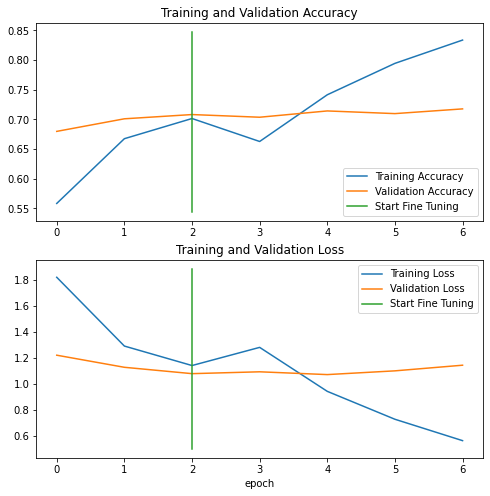

In [42]:
compare_historys(feature_extraction_history,fine_tune_history,initial_epochs=3)

## Load and evaluate checkpoint weights
We can load in and evaluate our model's checkpoints by:

1. Cloning our model using tf.keras.models.clone_model() to make a copy of our feature extraction model with reset weights.
2. Calling the load_weights() method on our cloned model passing it the path to where our checkpointed weights are stored.
3. Calling evaluate() on the cloned model with loaded weights.

A reminder, checkpoints are helpful for when you perform an experiment such as fine-tuning your model. In the case you fine-tune your feature extraction model and find it doesn't offer any improvements, you can always revert back to the checkpointed version of your model.

In [44]:
cloned_model = tf.keras.models.clone_model(model)
cloned_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 910,821
Non-trainable params: 3,268,131
_________________________________________________________________


In [45]:
# Load checkpointed weights into cloned_model (Feature Extraction Model)
cloned_model.load_weights(checkpoint_path)

In [46]:
# Re-compile the model
cloned_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [47]:
# Evaluate cloned model with loaded weights (should be same score as trained model)
results_cloned_model_with_loaded_weights = cloned_model.evaluate(test_data)

790/790 [==============================] - 50s 61ms/step - loss: 1.0908 - accuracy: 0.7042


In [48]:
# Loaded checkpoint weights should return very similar results to checkpoint weights prior to saving
import numpy as np
assert np.isclose(feature_extraction_results, results_cloned_model_with_loaded_weights).all() # check if all elements in array are close

In [50]:
# Check the layers in the base model and see what dtype policy they're using
for layer in cloned_model.layers[1].layers[:20]: # check only the first 20 layers to save space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <P

In [53]:
# Are any of the layers in our model frozen?
for layer in cloned_model.layers:
  layer.trainable = True # set all layers to trainable
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")


input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [54]:
# Check the layers in the base model and see what dtype policy they're using
for layer in cloned_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed_float

The EarlyStopping callback monitors a specified model performance metric (e.g. val_loss) and when it stops improving for a specified number of epochs, automatically stops training.

Using the EarlyStopping callback combined with the ModelCheckpoint callback saving the best performing model automatically, we could keep our model training for an unlimited number of epochs until it stops improving.

Let's set both of these up to monitor our model's val_loss.

In [55]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

Woohoo! Fine-tuning callbacks ready.

If you're planning on training large models, the ModelCheckpoint and EarlyStopping are two callbacks you'll want to become very familiar with.

We're almost ready to start fine-tuning our model but there's one more callback we're going to implement: ReduceLROnPlateau.

Remember how the learning rate is the most important model hyperparameter you can tune? (if not, treat this as a reminder).

Well, the ReduceLROnPlateau callback helps to tune the learning rate for you.

Like the ModelCheckpoint and EarlyStopping callbacks, the ReduceLROnPlateau callback montiors a specified metric and when that metric stops improving, it reduces the learning rate by a specified factor (e.g. divides the learning rate by 10).

🤔 Question: Why lower the learning rate?

Imagine having a coin at the back of the couch and you're trying to grab with your fingers.

Now think of the learning rate as the size of the movements your hand makes towards the coin.

The closer you get, the smaller you want your hand movements to be, otherwise the coin will be lost.

Our model's ideal performance is the equivalent of grabbing the coin. So as training goes on and our model gets closer and closer to it's ideal performance (also called convergence), we want the amount it learns to be less and less.

To do this we'll create an instance of the ReduceLROnPlateau callback to monitor the validation loss just like the EarlyStopping callback.

Once the validation loss stops improving for two or more epochs, we'll reduce the learning rate by a factor of 5 (e.g. 0.001 to 0.0002).

And to make sure the learning rate doesn't get too low (and potentially result in our model learning nothing), we'll set the minimum learning rate to 1e-7.

In [56]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

Learning rate reduction ready to go!

Now before we start training, we've got to recompile our model.

We'll use sparse categorical crossentropy as the loss and since we're fine-tuning, we'll use a 10x lower learning rate than the Adam optimizers default (1e-4 instead of 1e-3).

In [57]:
# Compile the model
cloned_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                     optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                     metrics=["accuracy"])

Okay, model compiled.

Now let's fit it on all of the data.

We'll set it up to run for up to 100 epochs.

Since we're going to be using the EarlyStopping callback, it might stop before reaching 100 epochs.

🔑 Note: Running the cell below will set the model up to fine-tune all of the pre-trained weights in the base model on all of the Food101 data. Doing so with unoptimized data pipelines and without mixed precision training will take a fairly long time per epoch depending on what type of GPU you're using (about 15-20 minutes on Colab GPUs). But don't worry, the code we've written above will ensure it runs much faster (more like 4-5 minutes per epoch).

In [58]:
# Start to fine-tune (all layers)
history_fine_tuned_all_layers_activated = cloned_model.fit(train_data,
                                                           epochs=100, # fine-tune for a maximum of 100 epochs
                                                           steps_per_epoch=len(train_data),
                                                           validation_data=test_data,
                                                           validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                           callbacks=[create_tensorboard_callback("TensorBoard", "fined_tuned_model_all_layers_activated"), # track the model training logs
                                                                      model_checkpoint, # save only the best model during training
                                                                      early_stopping, # stop model after X epochs of no improvements
                                                                      reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: TensorBoard/fined_tuned_model_all_layers_activated/20210820-154757
Epoch 1/100
2368/2368 [==============================] - 306s 124ms/step - loss: 0.9845 - accuracy: 0.7346 - val_loss: 0.7915 - val_accuracy: 0.7802
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


Epoch 2/100
2368/2368 [==============================] - 303s 127ms/step - loss: 0.5904 - accuracy: 0.8380 - val_loss: 0.7777 - val_accuracy: 0.7913
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


Epoch 3/100
2368/2368 [==============================] - 300s 126ms/step - loss: 0.3357 - accuracy: 0.9046 - val_loss: 0.8163 - val_accuracy: 0.7839
Epoch 4/100
2368/2368 [==============================] - 307s 129ms/step - loss: 0.1728 - accuracy: 0.9498 - val_loss: 0.9397 - val_accuracy: 0.7757

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 5/100
2368/2368 [==============================] - 299s 126ms/step - loss: 0.0552 - accuracy: 0.9859 - val_loss: 1.0458 - val_accuracy: 0.8008


In [59]:
fine_tuned_all_data_results = cloned_model.evaluate(test_data)
fine_tuned_all_data_results

790/790 [==============================] - 47s 60ms/step - loss: 1.0419 - accuracy: 0.7982


[1.0419456958770752, 0.7982178330421448]

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [61]:
model.save("drive/MyDrive/fine_tuned_full_data_model")

INFO:tensorflow:Assets written to: drive/MyDrive/fine_tuned_full_data_model/assets


INFO:tensorflow:Assets written to: drive/MyDrive/fine_tuned_full_data_model/assets


In [ ]:
!tensorboard dev upload --logdir ./TensorBoard \
  --name "Fine-tuning EfficientNetB0 on all Food101 Data" \
  --description "Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001" \
  --one_shot

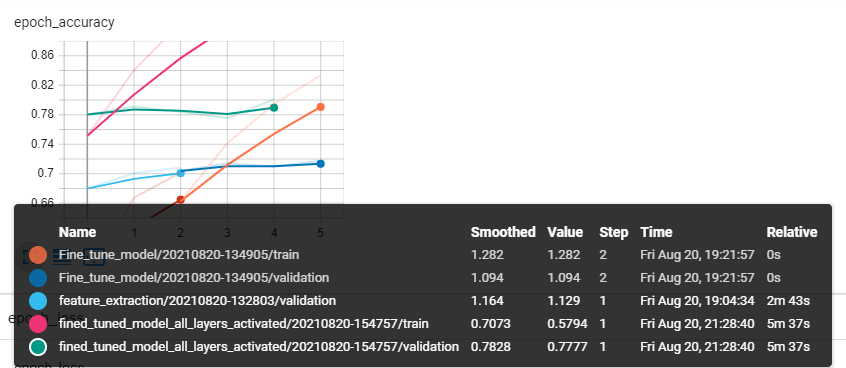

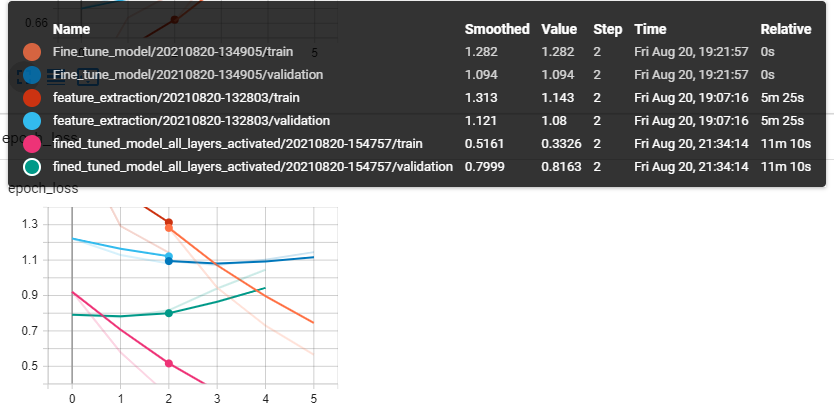

In [63]:
# View past TensorBoard experiments
!tensorboard dev list

2021-08-20 16:33:00.646305: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
https://tensorboard.dev/experiment/mHweXGZrTQ6jMS55N5btVQ/
	Name                 Fine-tuning EfficientNetB0 on all Food101 Data
	Description          Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001
	Id                   mHweXGZrTQ6jMS55N5btVQ
	Created              2021-08-20 16:29:53 (3 minutes ago)
	Updated              2021-08-20 16:29:57 (3 minutes ago)
	Runs                 6
	Tags                 3
	Scalars              48
	Tensor bytes         0
	Binary object bytes  2901247
https://tensorboard.dev/experiment/cONzu3FBTzWqwrNUr1ur9g/
	Name                 Transfer Learning Experiments with 10 Food101 Classes
	Description          A Series of different transfer learning experiments with varying amounts of data and fine-tuning.
	Id                   cONzu3FBTzWqwrNUr1ur9g
	Created              2021

## Making predictions using cloned_model

In [65]:
# Making predictions
pred = cloned_model.predict(test_data)

KeyboardInterrupt: ignored

In [66]:
# View first 10 predictions
pred[:10]

array([[1.4809397e-12, 3.4975120e-12, 5.7181320e-16, ..., 1.5390143e-16,
        5.1102922e-10, 4.2251600e-15],
       [6.8100297e-07, 1.3604660e-15, 6.0007913e-04, ..., 1.5022685e-05,
        2.0682269e-09, 8.6579810e-08],
       [1.0615763e-06, 3.4860184e-09, 8.0252699e-10, ..., 1.7618437e-01,
        2.0260539e-07, 3.2259657e-05],
       ...,
       [1.6886730e-03, 1.7954372e-11, 2.9265623e-09, ..., 4.6766333e-09,
        2.2757811e-06, 4.3866826e-06],
       [3.4528564e-20, 4.4335556e-20, 2.1394247e-21, ..., 1.2293021e-17,
        1.4350380e-14, 4.2178111e-14],
       [1.8631628e-02, 4.8823489e-12, 2.5836580e-10, ..., 2.9692993e-07,
        4.6784004e-10, 1.4388812e-06]], dtype=float32)

In [67]:
# View first 10 predictions class
pred_class = pred.argmax(axis=1)
pred_class[:10]

array([44, 16, 16, 79, 51, 12,  3, 17, 13, 42])

In [70]:
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Visualizing on custom images

In [78]:
# Get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2021-08-20 17:01:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 74.125.137.128, 142.250.141.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.1s    

2021-08-20 17:01:34 (87.9 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [80]:
# Get the custom food images filepaths
import os
custom_food_images = ["custom_food_images/" + i for i in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/sushi.jpeg']

In [81]:
# Create a function to load and prepare images
def preprocessed_image(filepath, img_shape=224, scale=True):
  """
  Reads in an image from filepath, turns it into a tensor and reshapes into
  specified shape (img_shape,img_shape,color channels=3)

  Args:
  filepath (str): path to target image
  img_shape (int): height/width dimension of target image size
  scale (bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
  Image tensor of shape (img_shape,img_shape,3)
  """
  # Read in the image
  img = tf.io.read_file(filepath)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape,img_shape])

  # Rescale the image (Yes/No)
  if scale:
    # rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img # don't need to rescale images for EfficientNet models in TensorFlow

In [82]:
custom_food_images_names = [i for i in os.listdir("custom_food_images")]
custom_food_images_names

['chicken_wings.jpeg',
 'hamburger.jpeg',
 'steak.jpeg',
 'pizza-dad.jpeg',
 'ramen.jpeg',
 'sushi.jpeg']

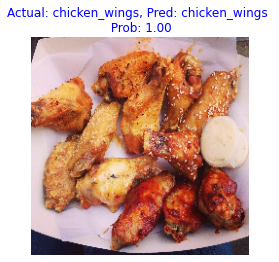

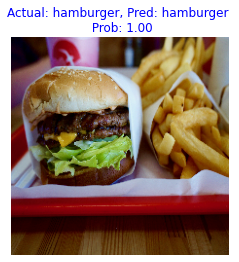

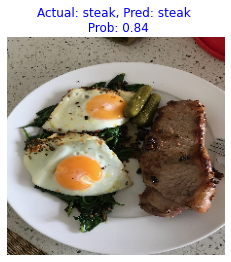

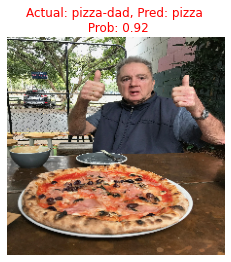

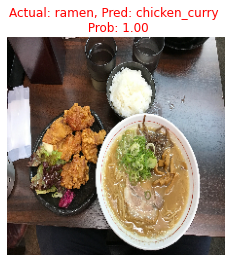

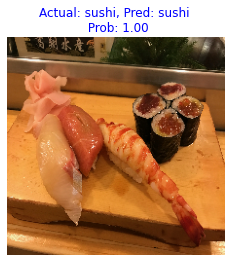

In [94]:
# Make predictions on and plot custom food images
for i,path in enumerate(custom_food_images):
  img = preprocessed_image(path,scale=False)
  pred = cloned_model.predict(tf.expand_dims(img,axis=0))
  pred_class_name = class_names[pred.argmax()]
  if custom_food_images_names[i].rstrip('.jpeg') == pred_class_name:
    color='blue'
  else:
    color='red'
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"Actual: {custom_food_images_names[i].rstrip('.jpeg')}, Pred: {pred_class_name} \n Prob: {pred.max():.2f}",color=color)
  plt.axis(False);